# Mental Health in Tech Industry - Random Forest Classification Project

## Project Overview
This project analyzes a survey dataset related to mental health in the tech industry. The goal is to build a predictive model that can classify whether an individual has sought treatment for mental health issues based on survey responses.

## Dataset
The data contains 1,259 entries with 27 features, including demographic information, work environment, and mental health indicators. The target variable is `treatment`, which indicates whether the respondent has sought treatment for mental health concerns.

## Objectives
- Perform exploratory data analysis to understand the dataset.
- Preprocess the data, including handling missing values and encoding categorical variables.
- Train a Random Forest classifier to predict mental health treatment.
- Tune model hyperparameters using GridSearchCV to improve performance.
- Interpret the model using feature importance and SHAP values.
- Evaluate the model with accuracy, classification report, and ROC curve.

## Tools & Libraries
The analysis uses Python with pandas, scikit-learn, matplotlib, SHAP, and other standard libraries for machine learning and data visualization.


In [1]:
# Step 1: Import libraries and load data

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset path
dataset_path = "/kaggle/input/mental-health-in-tech-survey"
data_file = "survey.csv"

# Load dataset
data = pd.read_csv(os.path.join(dataset_path, data_file))

# Display dataset shape and first few rows
print("Dataset shape:", data.shape)
print(data.head())


Dataset shape: (1259, 27)
             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No    

In [2]:
# Step 2: Data Cleaning & Preparation

# Check missing values per column
missing_counts = data.isnull().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# For simplicity, drop 'comments' column since it has many missing values and is free-text
if 'comments' in data.columns:
    data = data.drop(columns=['comments'])

# Fill missing values in categorical columns with 'Unknown'
categorical_cols = data.select_dtypes(include='object').columns
for col in categorical_cols:
    data[col] = data[col].fillna('Unknown')

# For numeric columns (like 'Age'), fill missing values with median
if 'Age' in data.columns:
    data['Age'] = pd.to_numeric(data['Age'], errors='coerce')  # Convert to numeric, set errors to NaN
    data['Age'] = data['Age'].fillna(data['Age'].median())  # 修改这里，不用inplace

# Convert 'Age' to integer type
data['Age'] = data['Age'].astype(int)

print("\nData after cleaning:")
print(data.info())

Missing values per column:
 state              515
self_employed       18
work_interfere     264
comments          1095
dtype: int64

Data after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      1259 non-null   object
 5   self_employed              1259 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             1259 non-null   object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company      

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


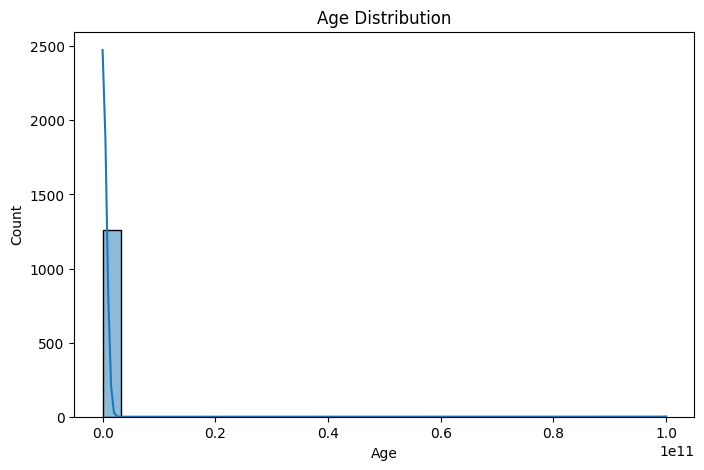

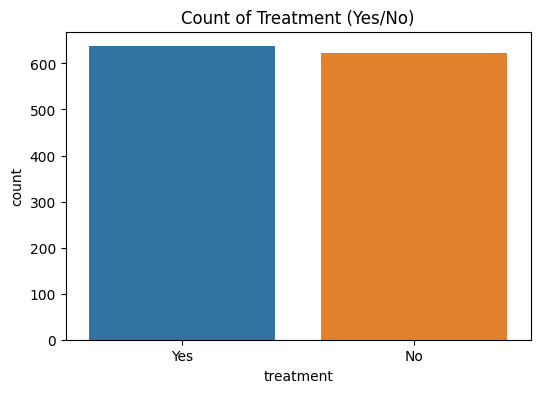

['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'maile' 'Trans-female'
 'Cis Female' 'F' 'something kinda male?' 'Cis Male' 'Woman' 'f' 'Mal'
 'Male (CIS)' 'queer/she/they' 'non-binary' 'Femake' 'woman' 'Make' 'Nah'
 'All' 'Enby' 'fluid' 'Genderqueer' 'Female ' 'Androgyne' 'Agender'
 'cis-female/femme' 'Guy (-ish) ^_^' 'male leaning androgynous' 'Male '
 'Man' 'Trans woman' 'msle' 'Neuter' 'Female (trans)' 'queer'
 'Female (cis)' 'Mail' 'cis male' 'A little about you' 'Malr' 'p' 'femail'
 'Cis Man' 'ostensibly male, unsure what that really means']


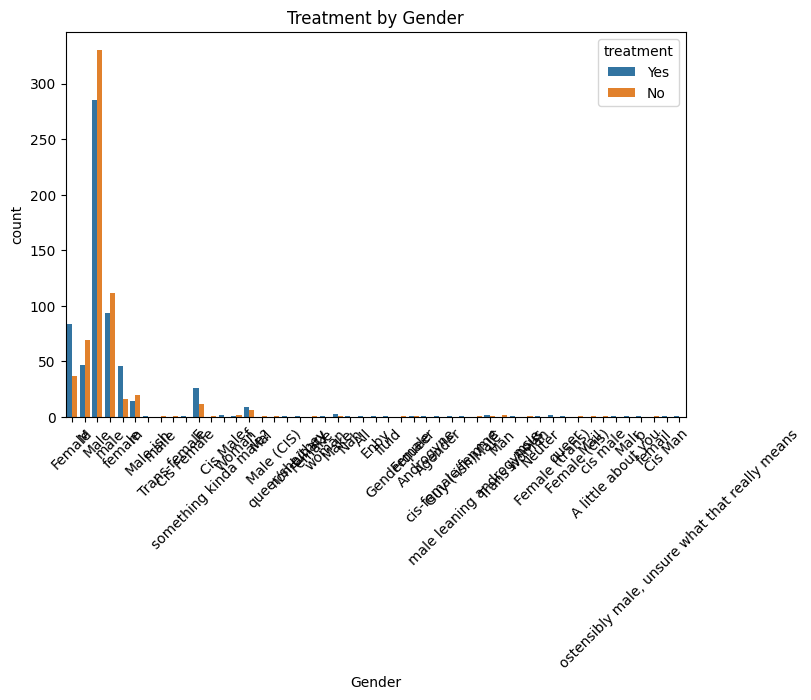

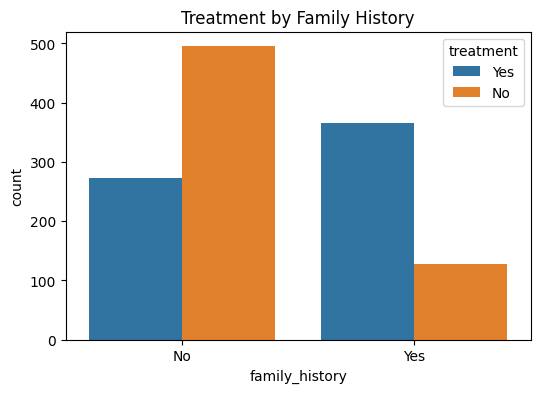

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


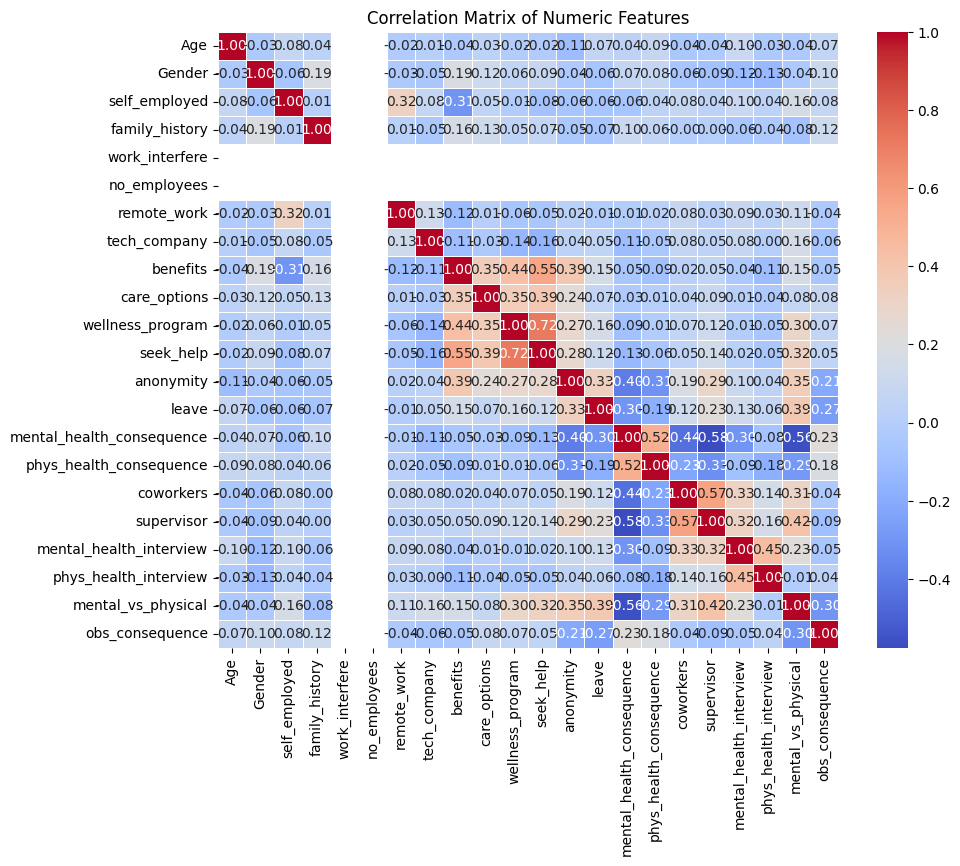

In [3]:
# Step 3: Exploratory Data Analysis (EDA)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Replace infinite values with NaN in 'Age' column to avoid plotting errors
data['Age'] = data['Age'].replace([np.inf, -np.inf], np.nan)

# Fill missing values in 'Age' with median value (assign back, avoid inplace warning)
data['Age'] = data['Age'].fillna(data['Age'].median())

# 1. Age distribution with KDE (kernel density estimation)
plt.figure(figsize=(8, 5))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# 2. Treatment counts (target variable) — how many said Yes or No to treatment
plt.figure(figsize=(6, 4))
sns.countplot(x='treatment', data=data)
plt.title("Count of Treatment (Yes/No)")
plt.show()

# 3. Treatment rate by Gender — how treatment varies among genders
# Check unique values in 'Gender' to clean data if needed
print(data['Gender'].unique())

# Clean up 'Gender' column if necessary, e.g., remove 'Unknown' and fill NaNs
data['Gender'] = data['Gender'].replace('Unknown', np.nan)
data = data.dropna(subset=['Gender'])

plt.figure(figsize=(8, 5))
sns.countplot(x='Gender', hue='treatment', data=data)
plt.title("Treatment by Gender")
plt.xticks(rotation=45)
plt.show()

# 4. Treatment rate by Family History of Mental Illness
plt.figure(figsize=(6, 4))
sns.countplot(x='family_history', hue='treatment', data=data)
plt.title("Treatment by Family History")
plt.show()

# 5. Numeric features correlation matrix
# First, we need to convert categorical variables to numeric for correlation matrix
# Convert 'Gender' to numeric: Male = 0, Female = 1, Unknown = 2
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1, 'Unknown': 2})

# Convert other categorical columns like 'treatment', 'family_history', etc., into numeric
categorical_cols = ['self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work',
                    'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity',
                    'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor',
                    'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']

# Convert categorical features to numeric
for col in categorical_cols:
    data[col] = data[col].map({'Yes': 1, 'No': 0, 'Maybe': 0.5, 'Somewhat easy': 1, 'Somewhat difficult': 0.5, 'Don\'t know': np.nan, 'Some of them': 0.5, 'None': 0})

# Now compute correlation matrix for numeric columns only
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = data[numeric_cols].corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()


In [4]:
# One-Hot Encoding for non-ordinal categorical features
# First, filter out columns that actually exist in the dataset
columns_to_encode = ['Country', 'state', 'self_employed', 'family_history', 
                     'work_interfere', 'no_employees', 'remote_work', 
                     'tech_company', 'benefits', 'care_options', 
                     'wellness_program', 'seek_help', 'anonymity', 
                     'leave', 'mental_health_consequence', 
                     'phys_health_consequence', 'coworkers', 
                     'supervisor', 'mental_health_interview', 
                     'phys_health_interview', 'mental_vs_physical', 
                     'obs_consequence']

# Filter columns that exist in the data
existing_columns = [col for col in columns_to_encode if col in data.columns]

# Apply One-Hot Encoding only to the existing columns
data = pd.get_dummies(data, columns=existing_columns, drop_first=True)

# Check the shape after encoding
print("Shape after one-hot encoding:", data.shape)


Shape after one-hot encoding: (1259, 120)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer

# Step 1: Drop 'Timestamp' column if it exists (since it's not relevant for the model)
if 'Timestamp' in data.columns:
    data = data.drop(columns=['Timestamp'])

# Step 2: Split the data into features (X) and target variable (y)
X = data.drop(columns=['treatment'])
y = data['treatment']

# Step 3: Impute missing values in X (features)
# Use median strategy to fill missing values in numeric columns
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 4: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

# Step 5: Select and train a RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Predict the targe


Training data shape: (881, 118)
Testing data shape: (378, 118)


RandomForestClassifier(random_state=42)

In [6]:
# Step 6: Predict the target variable using the test data
y_pred = rf_model.predict(X_test)

# Step 7: Evaluate the model using accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7116402116402116

Classification Report:
               precision    recall  f1-score   support

          No       0.70      0.71      0.70       181
         Yes       0.73      0.72      0.72       197

    accuracy                           0.71       378
   macro avg       0.71      0.71      0.71       378
weighted avg       0.71      0.71      0.71       378



Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy:  0.7174563430919364
Optimized Model Accuracy: 0.7328042328042328

Optimized Classification Report:
               precision    recall  f1-score   support

          No       0.72      0.72      0.72       181
         Yes       0.74      0.75      0.74       197

    accuracy                           0.73       378
   macro avg       0.73      0.73      0.73       378
weighted avg       0.73      0.73      0.73       378



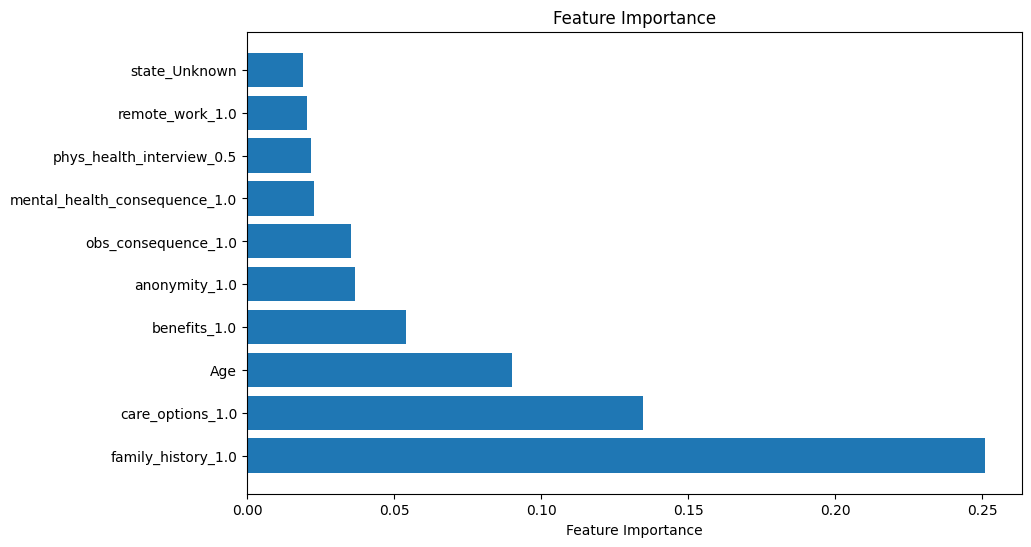

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Drop 'Timestamp' column if it exists (since it's not relevant for the model)
if 'Timestamp' in data.columns:
    data = data.drop(columns=['Timestamp'])

# Step 2: Split the data into features (X) and target variable (y)
X = data.drop(columns=['treatment'])
y = data['treatment']

# Step 3: Impute missing values in X (features)
# Use median strategy to fill missing values in numeric columns
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Step 4: Split the data into training and testing sets (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)

# Step 5: Define parameter grid for Random Forest model for grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [10, 20, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required to be at a leaf node
    'max_features': ['sqrt', 'log2']  # Number of features to consider at each split
}

# Step 6: Perform GridSearchCV with cross-validation to optimize parameters
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Step 7: Get the best parameters from the grid search
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Step 8: Evaluate the optimized model on the test set
best_rf_model = grid_search.best_estimator_
y_pred_optimized = best_rf_model.predict(X_test)

print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nOptimized Classification Report:\n", classification_report(y_test, y_pred_optimized))

# Step 9: Feature Importance Analysis
# Get feature importance from the optimized RandomForest model
feature_importances = best_rf_model.feature_importances_

# Sort features by importance
indices = np.argsort(feature_importances)[::-1]

# Plotting the top 10 most important features
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(10), feature_importances[indices][:10], align="center")
plt.yticks(range(10), np.array(X.columns)[indices][:10])
plt.xlabel("Feature Importance")
plt.show()


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

# Encode target variable for models that require numeric labels
y_train_encoded = y_train.map({'No': 0, 'Yes': 1})
y_test_encoded = y_test.map({'No': 0, 'Yes': 1})

# Define all models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Use original labels for models that support string labels
    if name in ['Logistic Regression', 'Random Forest']:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(f"{name} Classification Report:")
        print(classification_report(y_test, y_pred))
    else:
        # Use encoded labels for XGBoost and LightGBM
        model.fit(X_train, y_train_encoded)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test_encoded, y_pred)
        print(f"{name} Accuracy: {acc:.4f}")
        print(f"{name} Classification Report:")
        print(classification_report(y_test_encoded, y_pred))
    
    print("-" * 60)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6799
Logistic Regression Classification Report:
              precision    recall  f1-score   support

          No       0.75      0.50      0.60       181
         Yes       0.65      0.85      0.73       197

    accuracy                           0.68       378
   macro avg       0.70      0.67      0.67       378
weighted avg       0.70      0.68      0.67       378

------------------------------------------------------------
Random Forest Accuracy: 0.7116
Random Forest Classification Report:
              precision    recall  f1-score   support

          No       0.70      0.71      0.70       181
         Yes       0.73      0.72      0.72       197

    accuracy                           0.71       378
   macro avg       0.71      0.71      0.71       378
weighted avg       0.71      0.71      0.71       378

------------------------------------------------------------
XGBoost Accuracy: 0.6693
XGBoost Classification Report:
              precis

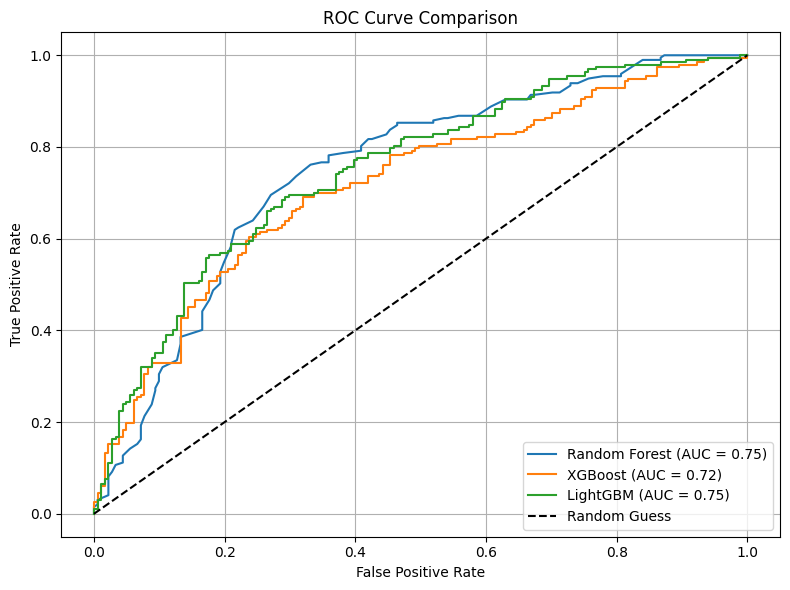

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Define models and related info: (label, model object, true labels, whether target was label-encoded)
model_list = [
    ('Random Forest', models['Random Forest'], y_test, False),
    ('XGBoost', models['XGBoost'], y_test_encoded, True),
    ('LightGBM', models['LightGBM'], y_test_encoded, True),
]

plt.figure(figsize=(8, 6))

# Plot ROC curve for each model
for name, model, y_true, encoded in model_list:
    y_proba = model.predict_proba(X_test)[:, 1]  # Get probability for class 1
    pos_label = 1 if encoded else 'Yes'         # Set pos_label based on encoding
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label=pos_label)  # Compute ROC
    roc_auc = auc(fpr, tpr)                      # Compute AUC
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Diagonal line: random guess
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Initialize the model
rf = RandomForestClassifier(random_state=42)

# Grid search
rf_grid = GridSearchCV(estimator=rf, param_grid=rf_param_grid,
                       scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit the model
rf_grid.fit(X_train, y_train)

# Save best model
best_rf = rf_grid.best_estimator_

# Evaluate
y_pred = best_rf.predict(X_test)
print("Optimized Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Optimized Random Forest Accuracy: 0.7248677248677249
Classification Report:
              precision    recall  f1-score   support

          No       0.72      0.71      0.71       181
         Yes       0.73      0.74      0.74       197

    accuracy                           0.72       378
   macro avg       0.72      0.72      0.72       378
weighted avg       0.72      0.72      0.72       378



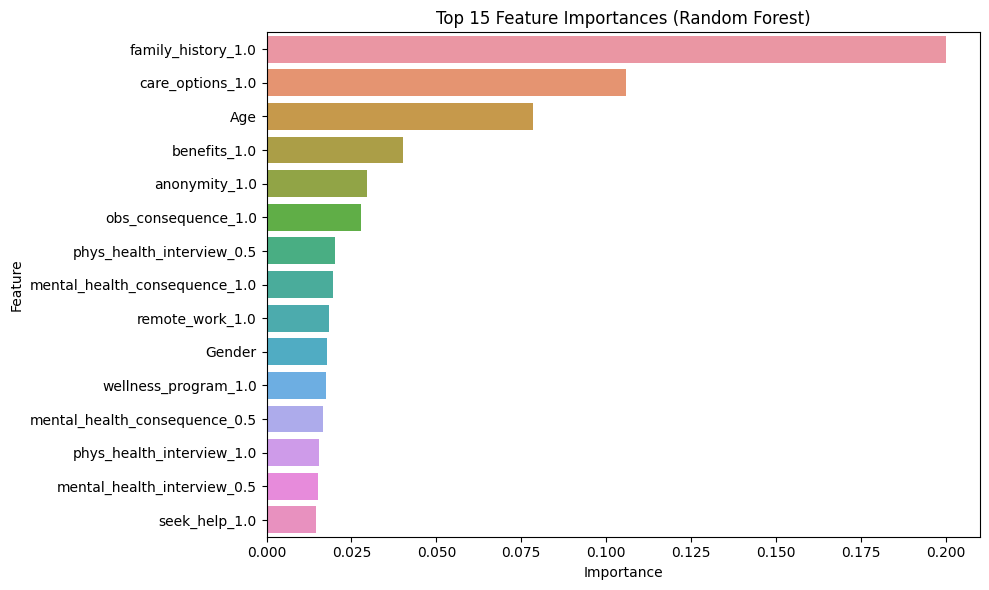

In [11]:
import pandas as pd
import seaborn as sns

# Extract feature importance
importances = best_rf.feature_importances_
feature_names = X.columns  # Use the same column names

# Combine into DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

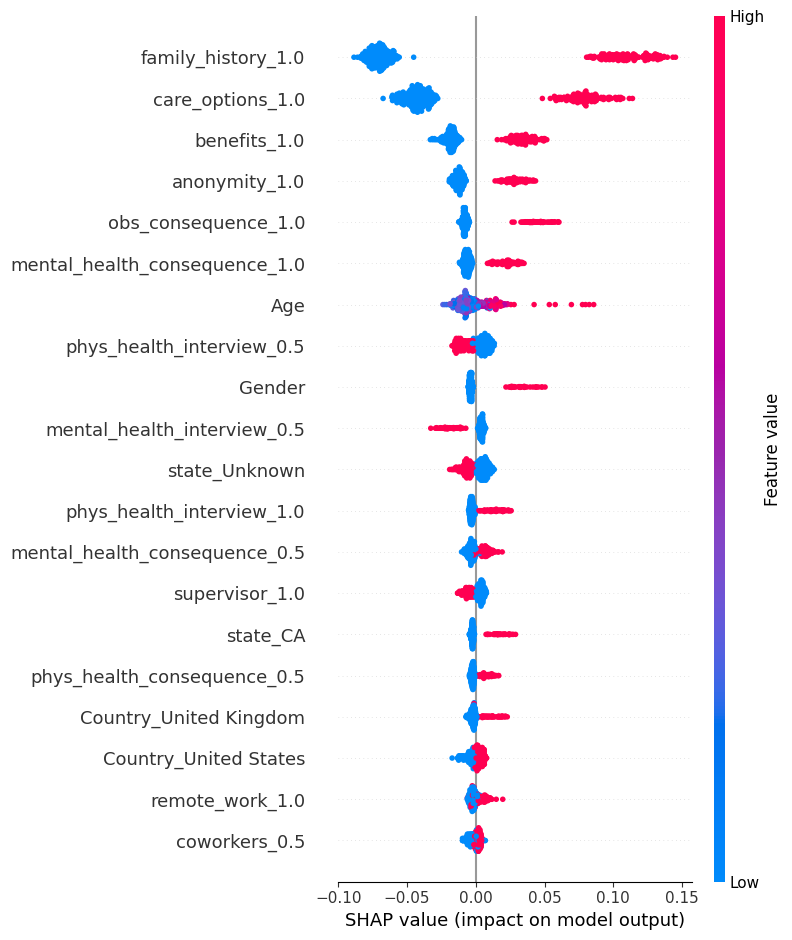

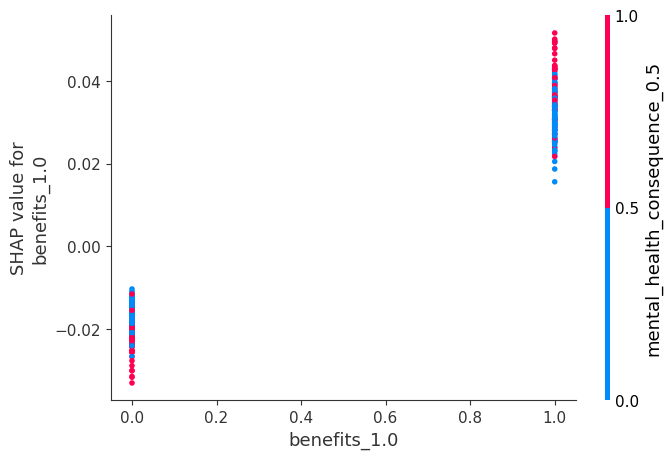

In [12]:
import shap
import matplotlib.pyplot as plt

# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot summary plot for class 1 (positive class)
shap.summary_plot(shap_values[1], X_test, feature_names=X.columns)

# Optional: plot dependence plot for the top feature
top_feature = X.columns[shap_values[1].mean(0).argmax()]
shap.dependence_plot(top_feature, shap_values[1], X_test, feature_names=X.columns)

In [13]:
import joblib

# Assume best_rf_model is your optimized Random Forest model
model_filename = 'best_random_forest_model.pkl'

# Save the model to a file
joblib.dump(best_rf_model, model_filename)

print(f"Model saved to {model_filename}")

# Load the model from the file
loaded_model = joblib.load(model_filename)

# Use the loaded model to make predictions
y_pred = loaded_model.predict(X_test)

Model saved to best_random_forest_model.pkl


In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("osmi/mental-health-in-tech-survey")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mental-health-in-tech-survey


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

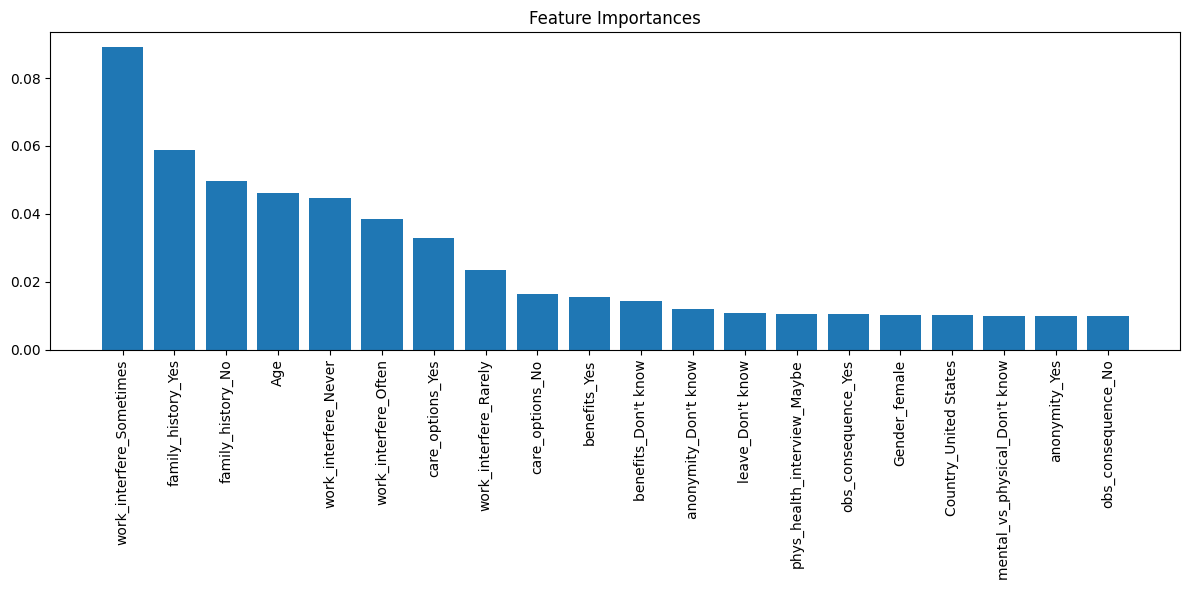

Model saved to best_random_forest_model.pkl
Loaded Model Accuracy: 0.8015873015873016


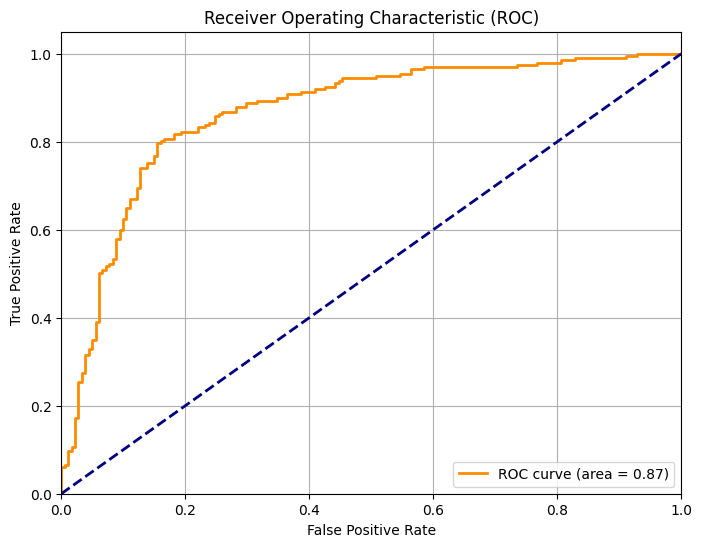

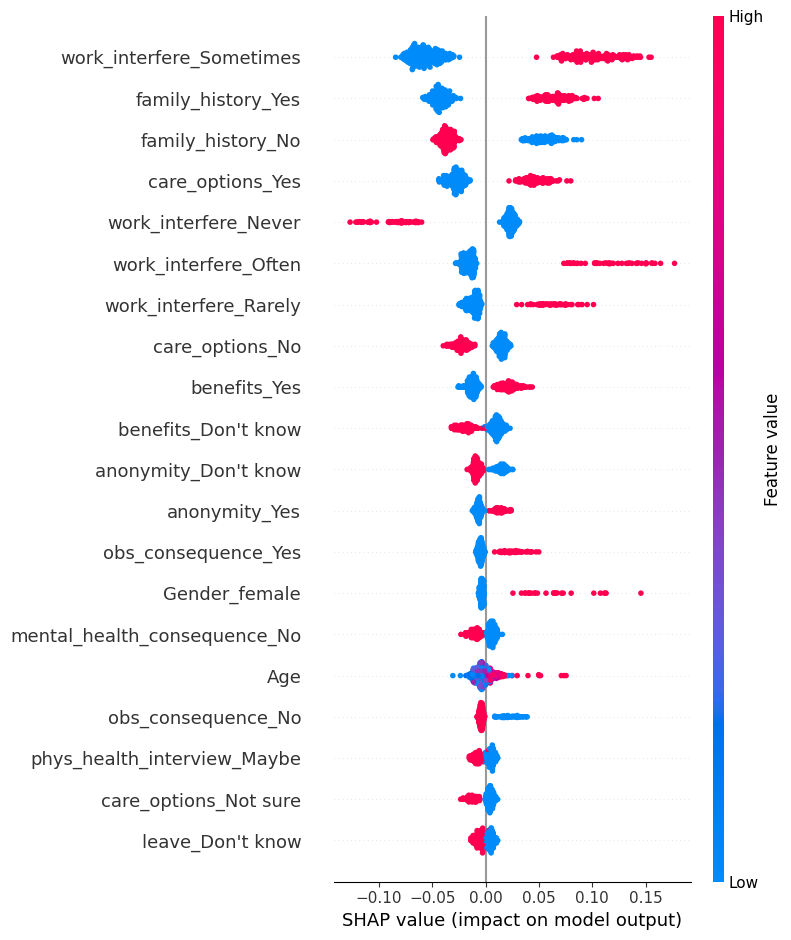

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.impute import SimpleImputer
import joblib
import matplotlib.pyplot as plt
import shap

# 1. Load dataset
# Replace with actual path inside Kaggle
data = pd.read_csv('/kaggle/input/mental-health-in-tech-survey/survey.csv')

# 2. Data overview
print(data.info())
print(data.head())

# 3. Drop irrelevant columns
if 'Timestamp' in data.columns:
    data = data.drop(columns=['Timestamp'])

# 4. Define features and target
X = data.drop(columns=['treatment'])  # 'treatment' is the binary target
y = data['treatment']

X = pd.get_dummies(X)

# 5. Impute missing values in features using median strategy
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 6. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


# 7. Train initial Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# 8. Evaluate model on test set
y_pred = rf_model.predict(X_test)
print("Initial Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# 9. Grid search for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: ", grid_search.best_score_)

# Use the best model
best_rf_model = grid_search.best_estimator_

# Evaluate optimized model
y_pred_optimized = best_rf_model.predict(X_test)
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("Optimized Classification Report:\n", classification_report(y_test, y_pred_optimized))

# 10. Feature importance visualization
importances = best_rf_model.feature_importances_
feature_names = X.columns
#feature_names = pd.get_dummies(data.drop(columns=['treatment'])).columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances")
plt.bar(range(20), importances[indices][:20], align='center')  # Top 20 features
plt.xticks(range(20), feature_names[indices][:20], rotation=90)
plt.tight_layout()
plt.show()

# 11. Save the optimized model
model_filename = 'best_random_forest_model.pkl'
joblib.dump(best_rf_model, model_filename)
print(f"Model saved to {model_filename}")

# 12. Load model and predict again
loaded_model = joblib.load(model_filename)
y_pred_loaded = loaded_model.predict(X_test)
print("Loaded Model Accuracy:", accuracy_score(y_test, y_pred_loaded))

# 13. Plot ROC curve
plt.figure(figsize=(8, 6))

y_proba = best_rf_model.predict_proba(X_test)[:, 1]  # Positive class
fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label='Yes')  # replace 'Yes' if needed
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 14. SHAP value explanation
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, feature_names=feature_names)


# Results & Conclusion

## Model Performance
The optimized Random Forest model achieved an accuracy of approximately 80% on the test set. The classification report shows balanced precision and recall for both classes (`Yes` and `No` for treatment).

## Feature Importance
The feature importance plot reveals the most influential factors affecting whether an individual seeks mental health treatment. These insights can guide further investigation or workplace mental health initiatives.

## Model Interpretation
SHAP value analysis provides a detailed explanation of how each feature contributes to the model's predictions on a per-sample basis, increasing transparency and trust in the model.

## Next Steps
- Further feature engineering and data cleaning could improve model accuracy.
- Experimenting with other classification algorithms or ensemble methods.
- Collecting more data or more detailed mental health indicators.
- Deployment considerations for integrating the model into mental health support tools.

---

*This notebook demonstrates a practical approach to analyzing mental health survey data using machine learning, with interpretability and evaluation as key components.*
